In [ ]:
import torch
GPU_name = torch.cuda.get_device_name()
print(GPU_name)
if GPU_name == "Tesla V100-SXM2-16GB":
    print("Get V100!")
    print("●●●●●")

Tesla V100-SXM2-16GB
Get V100!
●●●●●


In [ ]:
#SNGAN reference https://github.com/hanyoseob/pytorch-SNGAN
# git clone https://github.com/hanyoseob/pytorch-SNGAN.git

#SAGAN reference https://github.com/heykeetae/Self-Attention-GAN
# !git clone https://github.com/heykeetae/Self-Attention-GAN.git

#SWAGAN reference https://github.com/rosinality/stylegan2-pytorch.git
!git clone https://github.com/rosinality/stylegan2-pytorch.git
!mv ./stylegan2-pytorch ./SWAGAN
!cp -r ./SWAGAN/* ./

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 383 (delta 3), reused 9 (delta 3), pack-reused 372
Receiving objects: 100% (383/383), 122.51 MiB | 28.17 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [ ]:
# rm -r SAGAN
# rm -r checkpoints
# rm -r faces
# rm -r logs
# rm crypko_data.zip

# !bash



In [ ]:

!pip install Ninja

import os
import time
import torch
import datetime

import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import save_image
# !pip uninstall matplotlib
# print( help('modules'))
# !pip install matplotlib
# print( help('modules'))

In [ ]:
import sys
import pprint
sys.path
sys.path.append('/content/SWAGAN')
sys.path.append('/content/SWAGAN/lpips')
sys.path.append('/content/SWAGAN/op')
pprint.pprint(sys.path)

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/SWAGAN',
 '/content/SWAGAN/lpips',
 '/content/SWAGAN/op']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


### Packages Installation

In [ ]:
# You may replace the workspace directory if you want.
workspace_dir = '/content/'

# Training progress bar
!pip install -q qqdm

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [ ]:
!gdown --id 1m8Sai2svfUSiTs1wA5BqOsO7SBbdTRuu --output "{workspace_dir}/crypko_data.zip"

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


Downloading...
From: https://drive.google.com/uc?id=1m8Sai2svfUSiTs1wA5BqOsO7SBbdTRuu
To: /content/crypko_data.zip
452MB [00:13, 33.7MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [ ]:
!unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

## Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2021)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [ ]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=(0.8,1.05), contrast=(1, 1.2), saturation=(1, 1.2), hue=(-0.05, 0.05)),
        # transforms.GaussianBlur(kernel_size = 3, sigma=(0.1, 2.0)),
        # transforms.RandomAffine(degrees = (-30, 30), translate=None, scale=None, shear=None, fill=250),
        # transforms.RandomRotation(degrees, expand=False, center=None, fill=0, resample=None)
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


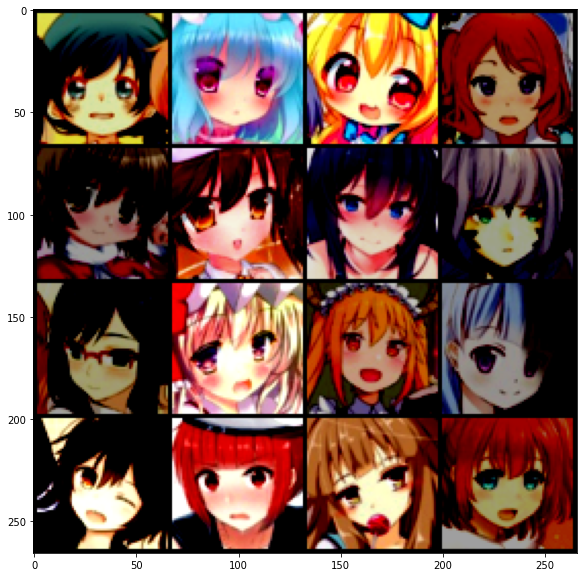

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

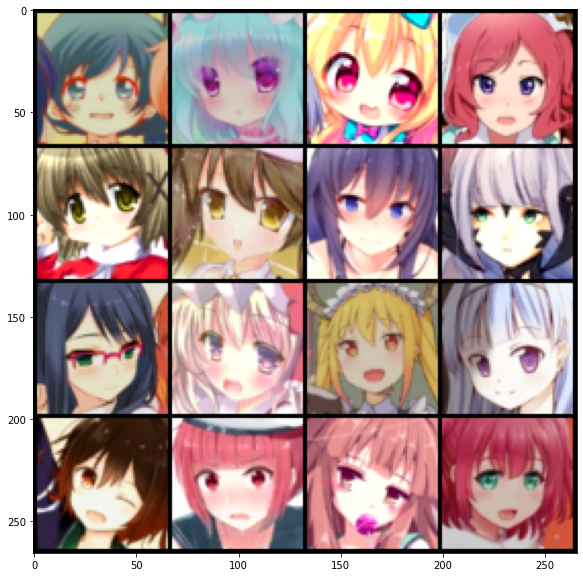

In [ ]:
#denormalize
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()


## Model
Here, we use DCGAN as the model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

In [ ]:
!mkdir -p DATA
!mv faces/ /content/DATA/faces/

In [ ]:
!python prepare_data.py --out "./DATAout" --n_worker 2 --size 64 "./DATA"

Make dataset of image sizes: 64
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:365: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:365: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
71314it [06:38, 179.14it/s]


In [ ]:
import argparse
import math
import random
import os

import numpy as np
import torch
from torch import nn, autograd, optim
from torch.nn import functional as F
from torch.utils import data
import torch.distributed as dist
from torchvision import transforms, utils
from tqdm import tqdm

try:
    import wandb

except ImportError:
    wandb = None


from dataset import MultiResolutionDataset
from SWAGAN.distributed import (
    get_rank,
    synchronize,
    reduce_loss_dict,
    reduce_sum,
    get_world_size,
)
from SWAGAN.op import conv2d_gradfix
# from SWAGAN.op import *
from SWAGAN.non_leaking import augment, AdaptiveAugment


def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)


def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)


def sample_data(loader):
    while True:
        for batch in loader:
            yield batch


def d_logistic_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)

    return real_loss.mean() + fake_loss.mean()


def d_r1_loss(real_pred, real_img):
    with conv2d_gradfix.no_weight_gradients():
        grad_real, = autograd.grad(
            outputs=real_pred.sum(), inputs=real_img, create_graph=True
        )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty


def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()

    return loss


def g_path_regularize(fake_img, latents, mean_path_length, decay=0.01):
    noise = torch.randn_like(fake_img) / math.sqrt(
        fake_img.shape[2] * fake_img.shape[3]
    )
    grad, = autograd.grad(
        outputs=(fake_img * noise).sum(), inputs=latents, create_graph=True
    )
    path_lengths = torch.sqrt(grad.pow(2).sum(2).mean(1))

    path_mean = mean_path_length + decay * (path_lengths.mean() - mean_path_length)

    path_penalty = (path_lengths - path_mean).pow(2).mean()

    return path_penalty, path_mean.detach(), path_lengths


def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return torch.randn(batch, latent_dim, device=device)

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises


def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return [make_noise(batch, latent_dim, 1, device)]


def set_grad_none(model, targets):
    for n, p in model.named_parameters():
        if n in targets:
            p.grad = None


def train(args, loader, generator, discriminator, g_optim, d_optim, g_ema, device):
    loader = sample_data(loader)

    pbar = range(args.iter)

    if get_rank() == 0:
        pbar = tqdm(pbar, initial=args.start_iter, dynamic_ncols=True, smoothing=0.01)

    mean_path_length = 0

    d_loss_val = 0
    r1_loss = torch.tensor(0.0, device=device)
    g_loss_val = 0
    path_loss = torch.tensor(0.0, device=device)
    path_lengths = torch.tensor(0.0, device=device)
    mean_path_length_avg = 0
    loss_dict = {}

    if args.distributed:
        g_module = generator.module
        d_module = discriminator.module

    else:
        g_module = generator
        d_module = discriminator

    accum = 0.5 ** (32 / (10 * 1000))
    ada_aug_p = args.augment_p if args.augment_p > 0 else 0.0
    r_t_stat = 0

    if args.augment and args.augment_p == 0:
        ada_augment = AdaptiveAugment(args.ada_target, args.ada_length, 8, device)

    sample_z = torch.randn(args.n_sample, args.latent, device=device)

    for idx in pbar:
        i = idx + args.start_iter

        if i > args.iter:
            print("Done!")

            break

        real_img = next(loader)
        real_img = real_img.to(device)

        requires_grad(generator, False)
        requires_grad(discriminator, True)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator(noise)

        if args.augment:
            real_img_aug, _ = augment(real_img, ada_aug_p)
            fake_img, _ = augment(fake_img, ada_aug_p)

        else:
            real_img_aug = real_img

        fake_pred = discriminator(fake_img)
        real_pred = discriminator(real_img_aug)
        d_loss = d_logistic_loss(real_pred, fake_pred)

        loss_dict["d"] = d_loss
        loss_dict["real_score"] = real_pred.mean()
        loss_dict["fake_score"] = fake_pred.mean()

        discriminator.zero_grad()
        d_loss.backward()
        d_optim.step()

        if args.augment and args.augment_p == 0:
            ada_aug_p = ada_augment.tune(real_pred)
            r_t_stat = ada_augment.r_t_stat

        d_regularize = i % args.d_reg_every == 0

        if d_regularize:
            real_img.requires_grad = True

            if args.augment:
                real_img_aug, _ = augment(real_img, ada_aug_p)

            else:
                real_img_aug = real_img

            real_pred = discriminator(real_img_aug)
            r1_loss = d_r1_loss(real_pred, real_img)

            discriminator.zero_grad()
            (args.r1 / 2 * r1_loss * args.d_reg_every + 0 * real_pred[0]).backward()

            d_optim.step()

        loss_dict["r1"] = r1_loss

        requires_grad(generator, True)
        requires_grad(discriminator, False)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator(noise)

        if args.augment:
            fake_img, _ = augment(fake_img, ada_aug_p)

        fake_pred = discriminator(fake_img)
        g_loss = g_nonsaturating_loss(fake_pred)

        loss_dict["g"] = g_loss

        generator.zero_grad()
        g_loss.backward()
        g_optim.step()

        g_regularize = i % args.g_reg_every == 0

        if g_regularize:
            path_batch_size = max(1, args.batch // args.path_batch_shrink)
            noise = mixing_noise(path_batch_size, args.latent, args.mixing, device)
            fake_img, latents = generator(noise, return_latents=True)

            path_loss, mean_path_length, path_lengths = g_path_regularize(
                fake_img, latents, mean_path_length
            )

            generator.zero_grad()
            weighted_path_loss = args.path_regularize * args.g_reg_every * path_loss

            if args.path_batch_shrink:
                weighted_path_loss += 0 * fake_img[0, 0, 0, 0]

            weighted_path_loss.backward()

            g_optim.step()

            mean_path_length_avg = (
                reduce_sum(mean_path_length).item() / get_world_size()
            )

        loss_dict["path"] = path_loss
        loss_dict["path_length"] = path_lengths.mean()

        accumulate(g_ema, g_module, accum)

        loss_reduced = reduce_loss_dict(loss_dict)

        d_loss_val = loss_reduced["d"].mean().item()
        g_loss_val = loss_reduced["g"].mean().item()
        r1_val = loss_reduced["r1"].mean().item()
        path_loss_val = loss_reduced["path"].mean().item()
        real_score_val = loss_reduced["real_score"].mean().item()
        fake_score_val = loss_reduced["fake_score"].mean().item()
        path_length_val = loss_reduced["path_length"].mean().item()

        if get_rank() == 0:
            pbar.set_description(
                (
                    f"d: {d_loss_val:.4f}; g: {g_loss_val:.4f}; r1: {r1_val:.4f}; "
                    f"path: {path_loss_val:.4f}; mean path: {mean_path_length_avg:.4f}; "
                    f"augment: {ada_aug_p:.4f}"
                )
            )

            if wandb and args.wandb:
                wandb.log(
                    {
                        "Generator": g_loss_val,
                        "Discriminator": d_loss_val,
                        "Augment": ada_aug_p,
                        "Rt": r_t_stat,
                        "R1": r1_val,
                        "Path Length Regularization": path_loss_val,
                        "Mean Path Length": mean_path_length,
                        "Real Score": real_score_val,
                        "Fake Score": fake_score_val,
                        "Path Length": path_length_val,
                    }
                )

            if i % 100 == 0:
                with torch.no_grad():
                    g_ema.eval()
                    sample, _ = g_ema([sample_z])
                    utils.save_image(
                        sample,
                        f"/content/drive/MyDrive/ML/HW6rosstyle/sample/{str(i).zfill(6)}.png",
                        nrow=int(args.n_sample ** 0.5),
                        normalize=True,
                        range=(-1, 1),
                    )

            if i % 100 == 0:
                torch.save(
                    {
                        "g": g_module.state_dict(),
                        "d": d_module.state_dict(),
                        "g_ema": g_ema.state_dict(),
                        "g_optim": g_optim.state_dict(),
                        "d_optim": d_optim.state_dict(),
                        "args": args,
                        "ada_aug_p": ada_aug_p,
                    },
                    f"/content/drive/MyDrive/ML/HW6rosstyle/{str(i).zfill(6)}.pt",
                )


if __name__ == "__main__":
    device = "cuda"
    p = os.path.join( workspace_dir, 'DATAout' )
    print(p)
    parser = argparse.ArgumentParser(description="StyleGAN2 trainer")

    parser.add_argument("path", type=str, default= p, help="path to the lmdb dataset")
    parser.add_argument('--arch', type=str, default='swagan', help='model architectures (stylegan2 | swagan)')
    parser.add_argument(
        "--iter", type=int, default=800000, help="total training iterations"
    )
    parser.add_argument(
        "--batch", type=int, default=64, help="batch sizes for each gpus"
    )
    parser.add_argument(
        "--n_sample",
        type=int,
        default=64,
        help="number of the samples generated during training",
    )
    parser.add_argument(
        "--size", type=int, default=64, help="image sizes for the model"
    )
    parser.add_argument(
        "--r1", type=float, default=10, help="weight of the r1 regularization"
    )
    parser.add_argument(
        "--path_regularize",
        type=float,
        default=2,
        help="weight of the path length regularization",
    )
    parser.add_argument(
        "--path_batch_shrink",
        type=int,
        default=2,
        help="batch size reducing factor for the path length regularization (reduce memory consumption)",
    )
    parser.add_argument(
        "--d_reg_every",
        type=int,
        default=16,
        help="interval of the applying r1 regularization",
    )
    parser.add_argument(
        "--g_reg_every",
        type=int,
        default=4,
        help="interval of the applying path length regularization",
    )
    parser.add_argument(
        "--mixing", type=float, default=0.9, help="probability of latent code mixing"
    )
    parser.add_argument(
        "--ckpt",
        type=str,
        default='/content/drive/MyDrive/ML/HW6rosstyle/015800.pt',
        help="path to the checkpoints to resume training",
    )
    parser.add_argument("--lr", type=float, default=0.002, help="learning rate")

    parser.add_argument(
        "--channel_multiplier",
        type=int,
        default=2,
        help="channel multiplier factor for the model. config-f = 2, else = 1",
    )
    parser.add_argument(
        "--wandb", action="store_true", help="use weights and biases logging"
    )
    parser.add_argument(
        "--local_rank", type=int, default=0, help="local rank for distributed training"
    )
    parser.add_argument(
        "--augment", action="store_true", help="apply non leaking augmentation"
    )
    parser.add_argument(
        "--augment_p",
        type=float,
        default=0,
        help="probability of applying augmentation. 0 = use adaptive augmentation",
    )
    parser.add_argument(
        "--ada_target",
        type=float,
        default=0.6,
        help="target augmentation probability for adaptive augmentation",
    )
    parser.add_argument(
        "--ada_length",
        type=int,
        default=500 * 1000,
        help="target duraing to reach augmentation probability for adaptive augmentation",
    )
    parser.add_argument(
        "--ada_every",
        type=int,
        default=256,
        help="probability update interval of the adaptive augmentation",
    )

    # args = parser.parse_args()
    args, unparsed = parser.parse_known_args()

    n_gpu = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
    args.distributed = n_gpu > 1

    if args.distributed:
        torch.cuda.set_device(args.local_rank)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        synchronize()

    args.latent = 512
    args.n_mlp = 8

    args.start_iter = 0

    if args.arch == 'stylegan2':
        from model import Generator, Discriminator

    elif args.arch == 'swagan':
        from swagan import Generator, Discriminator

    generator = Generator(
        args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
    ).to(device)
    discriminator = Discriminator(
        args.size, channel_multiplier=args.channel_multiplier
    ).to(device)
    g_ema = Generator(
        args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
    ).to(device)
    g_ema.eval()
    accumulate(g_ema, generator, 0)

    g_reg_ratio = args.g_reg_every / (args.g_reg_every + 1)
    d_reg_ratio = args.d_reg_every / (args.d_reg_every + 1)

    g_optim = optim.Adam(
        generator.parameters(),
        lr=args.lr * g_reg_ratio,
        betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
    )
    d_optim = optim.Adam(
        discriminator.parameters(),
        lr=args.lr * d_reg_ratio,
        betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio),
    )

    if args.ckpt is not None:
        print("load model:", args.ckpt)

        ckpt = torch.load(args.ckpt, map_location=lambda storage, loc: storage)

        try:
            ckpt_name = os.path.basename(args.ckpt)
            args.start_iter = int(os.path.splitext(ckpt_name)[0])

        except ValueError:
            pass

        generator.load_state_dict(ckpt["g"])
        discriminator.load_state_dict(ckpt["d"])
        g_ema.load_state_dict(ckpt["g_ema"])

        g_optim.load_state_dict(ckpt["g_optim"])
        d_optim.load_state_dict(ckpt["d_optim"])

    if args.distributed:
        generator = nn.parallel.DistributedDataParallel(
            generator,
            device_ids=[args.local_rank],
            output_device=args.local_rank,
            broadcast_buffers=False,
        )

        discriminator = nn.parallel.DistributedDataParallel(
            discriminator,
            device_ids=[args.local_rank],
            output_device=args.local_rank,
            broadcast_buffers=False,
        )

    transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )
    print(args.path)
    print(args.size)
    dataset = MultiResolutionDataset(p, transform, args.size)
    loader = data.DataLoader(
        dataset,
        batch_size=args.batch,
        sampler=data_sampler(dataset, shuffle=True, distributed=args.distributed),
        drop_last=True,
    )

    if get_rank() == 0 and wandb is not None and args.wandb:
        wandb.init(project="stylegan 2")

    train(args, loader, generator, discriminator, g_optim, d_optim, g_ema, device)

# !python -m torch.distributed.launch --nproc_per_node=N_GPU --master_port=PORT train.py --batch BATCH_SIZE LMDB_PATH
# !python -m torch.distributed.launch --nproc_per_node=N_GPU --master_port=PORT train.py --arch swagan --batch BATCH_SIZE LMDB_PATH

/content/DATAout
load model: /content/drive/MyDrive/ML/HW6rosstyle/015800.pt


  2%|▏         | 15800/800000 [00:00<?, ?it/s]

/root/.local/share/jupyter/runtime/kernel-fbf9e3cb-7bfc-418f-a840-537f036899e3.json
64


d: 1.2318; g: 1.0446; r1: 0.0000; path: 0.0441; mean path: 0.0021; augment: 0.0000:   2%|▏         | 15800/800000 [00:01<01:26, 9117.01it/s]/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
d: 1.3172; g: 0.7856; r1: 0.0065; path: 0.0009; mean path: 0.2080; augment: 0.0000:   3%|▎         | 24092/800000 [2:45:53<255:16:40,  1.18s/it]

KeyboardInterrupt: ignored

In [ ]:
!mkdir -p sample

In [ ]:
import argparse

import torch
from torchvision import utils
from model import Generator
from tqdm import tqdm


def generate(args, g_ema, device, mean_latent):

    with torch.no_grad():
        g_ema.eval()
        for i in tqdm(range(args.pics)):
            sample_z = torch.randn(args.sample, args.latent, device=device)

            sample, _ = g_ema(
                [sample_z], truncation=args.truncation, truncation_latent=mean_latent
            )

            utils.save_image(
                sample,
                f"sample/{str(i).zfill(6)}.jpg",
                nrow=1,
                normalize=True,
                range=(-1, 1),
            )


if __name__ == "__main__":
    device = "cuda"

    parser = argparse.ArgumentParser(description="Generate samples from the generator")

    parser.add_argument(
        "--size", type=int, default=64, help="output image size of the generator"
    )
    parser.add_argument(
        "--sample",
        type=int,
        default=1,
        help="number of samples to be generated for each image",
    )
    parser.add_argument(
        "--pics", type=int, default=1000, help="number of images to be generated"
    )
    parser.add_argument("--truncation", type=float, default=0.6, help="truncation ratio") # 0.5 and 1. It is set at 0.75
    parser.add_argument(
        "--truncation_mean",
        type=int,
        default=4096,
        help="number of vectors to calculate mean for the truncation",
    )
    parser.add_argument(
        "--ckpt",
        type=str,
        default="/content/drive/MyDrive/ML/HW6rosstyle/024000.pt",
        help="path to the model checkpoint",
    )
    parser.add_argument(
        "--channel_multiplier",
        type=int,
        default=2,
        help="channel multiplier of the generator. config-f = 2, else = 1",
    )

    args, unparsed = parser.parse_known_args()  
    args.latent = 512
    args.n_mlp = 8


    checkpoint = torch.load(args.ckpt)

    g_ema.load_state_dict(checkpoint["g"])

    if args.truncation < 1:
        with torch.no_grad():
            mean_latent = g_ema.mean_latent(args.truncation_mean)
    else:
        mean_latent = None

    generate(args, g_ema, device, mean_latent)

    d_ema = Discriminator(
        args.size, channel_multiplier=args.channel_multiplier
    ).to(device)
    discriminator.load_state_dict(ckpt["d"])



        


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)

100%|██████████| 1000/1000 [00:13<00:00, 73.11it/s]


### Compress the generated images using **tar**.


In [ ]:

# Compress the images.
%cd sample
!tar -zcf ../images.tgz *.jpg
%cd ..

# os.makedirs(gpred_dir, exist_ok=True)
# for i in range(1000):
#     torchvision.utils.save_image(imgs_sample[i], f'drive/MyDrive/ML/HW6/pred/output/{i+1}.jpg')
# %cd /content/drive/MyDrive/ML/HW6/pred/output
# !tar -zcf ../images.tgz *.jpg
# %cd ..    

/content/sample
/content
